In [1]:
data_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track'
train_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train'
val_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/val'

In [2]:
import os
import numpy as np
from pathlib import Path
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class CustomDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        self.imgs_path = data_path + '/images'
        self.masks_path = data_path + '/masks'
        self.transforms = transforms

        self.imgs_filename = list(sorted(os.listdir(self.imgs_path)))
        self.masks_filename = list(sorted(os.listdir(self.masks_path)))
        
    def __len__(self):
        return len(self.imgs_filename)
            
    # Get item for training
    def __getitem__(self, idx):
        img = read_image(self.imgs_path + '/' + self.imgs_filename[idx])
        img = img.to(dtype=torch.float32)
        mask = read_image(self.masks_path + '/' + self.masks_filename[idx])

        obj_ids = torch.unique(mask) # (N)
        obj_ids = obj_ids[1:] # first id is the background, so remove it
        if len(obj_ids) == 0:
             boxes = torch.zeros((0, 4), dtype=torch.float32)
             masks = torch.zeros((0, mask.shape[1], mask.shape[2]), dtype=torch.uint8)
             labels = torch.zeros((0,), dtype=torch.int64)
             area = torch.zeros((0,), dtype=torch.float32)
             iscrowd = torch.zeros((0,), dtype=torch.int64)
             num_objs = 0 # Still 0

             target = {}
             target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
             target["masks"] = tv_tensors.Mask(masks)
             target["labels"] = labels
             target["image_id"] = idx # Use idx as image_id
             target["area"] = area
             target["iscrowd"] = iscrowd

             if self.transforms is not None:
                 img, target = self.transforms(img, target)

             return img, target


        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        
        boxes = masks_to_boxes(masks)
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        valid_boxes_mask = (widths > 0) & (heights > 0)

        boxes = boxes[valid_boxes_mask]
        masks = masks[valid_boxes_mask]
        
        labels = torch.ones((len(obj_ids),), dtype=torch.int64) 
        labels = labels[valid_boxes_mask]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64) 
        iscrowd = iscrowd[valid_boxes_mask] 

        num_objs = boxes.shape[0] 
        if num_objs == 0:
             boxes = torch.zeros((0, 4), dtype=torch.float32)
             masks = torch.zeros((0, masks.shape[1], masks.shape[2]), dtype=torch.uint8) # Maintain mask shape
             labels = torch.zeros((0,), dtype=torch.int64)
             area = torch.zeros((0,), dtype=torch.float32)
             iscrowd = torch.zeros((0,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            target["boxes"].canvas_size = F.get_size(img)

        return img, target

dataset_train = CustomDataset(train_path)
dataset_train[0]

(Image([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], ),
 {'boxes': BoundingBoxes([[148., 193., 274., 274.],
                 [274., 192., 353., 284.],
                 [ 83., 162., 187., 283.],
                 [182., 272., 321., 419.],
                 [244., 272.

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

# Define your number of classes (e.g., 1 object class + background)
num_classes = 2
weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = maskrcnn_resnet50_fpn_v2(weights=weights)

in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # Features for the mask head

# Create a new box predictor with the same input features but your num_classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

hidden_layer = 256 # A common choice for the hidden layer size in the mask head
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

print("Box Predictor (new):")
print(model.roi_heads.box_predictor)
print("\nMask Predictor (new):")
print(model.roi_heads.mask_predictor)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 209MB/s] 


Box Predictor (new):
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

Mask Predictor (new):
MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
)


In [5]:
from sklearn.model_selection import train_test_split

import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

train_augmentation = T.Compose([
    # T.Resize((512,512)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    # T.RandomSolarize(threshold=20.0),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 
val_augmentation = T.Compose([
    # T.Resize((512,512)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    """
    Since the number of objects varies per image, we collate the images and targets
    into lists. The model expects a list of images and a list of targets dictionaries.
    """
    # batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    images = [item[0] for item in batch] # This will be a list of image tensors/tv_tensors.Image
    targets = [item[1] for item in batch] # This will be a list of target dictionaries
    return images, targets

train_dataset = CustomDataset(train_path, train_augmentation)
val_dataset = CustomDataset(train_path, val_augmentation)
train_idx, valid_idx = train_test_split(np.arange(len(train_dataset)),
                                            test_size=0.2,
                                            shuffle=True)

train_subset = Subset(train_dataset, train_idx)
validation_subset = Subset(val_dataset, valid_idx)

batch_size = 4
num_workers = 0
train_dataloader = DataLoader(train_subset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn = collate_fn)
val_dataloader = DataLoader(validation_subset, batch_size=batch_size, num_workers=num_workers, shuffle=False, collate_fn = collate_fn)

n_epochs = 30
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-4, epochs=n_epochs, steps_per_epoch=len(train_dataloader), anneal_strategy='cos', final_div_factor=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
global_step = 0

In [6]:
import torch
import numpy as np
from tqdm import tqdm
from torchmetrics.segmentation import MeanIoU

def evaluate_model(model, dataloader, device, metric): # Pass the metric object
    """
    Evaluates the model using Mean Average Precision (mAP) for segmentation masks.
    """
    print('Evaluating...')
    model.eval()
    MASK_THRESHOLD = 0.5

    metric.reset()

    with torch.no_grad():
        with tqdm(dataloader, desc="Evaluating", total=len(dataloader), leave=False) as pbar:
            for images, targets in pbar:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    
                predictions = model(images)
                batch_pred_semantic_masks = []
                batch_gt_semantic_masks = []

                for i in range(len(images)):
                    H, W = images[i].shape[-2:]

                    # --- Process Predictions ---
                    preds_i = predictions[i]
                    pred_masks_i = preds_i['masks'] # Shape: [N_pred, 1, H, W] or [N_pred, H, W] (probabilities)

                    pred_semantic_i = torch.zeros((H, W), dtype=torch.long, device=device)

                    if pred_masks_i.numel() > 0:
                        # Binarize predicted masks based on threshold and combine
                        pred_binary_masks_i = (pred_masks_i > MASK_THRESHOLD).squeeze(1) # [N_pred, H, W] bool or uint8
                        pred_semantic_i = torch.any(pred_binary_masks_i, dim=0).to(torch.long) # [H, W] long

                    # --- Process Targets ---
                    targets_i = targets[i]
                    gt_masks_i = targets_i['masks'] # Shape: [N_gt, H, W] or [N_gt, 1, H, W] (binary uint8)

                    gt_semantic_i = torch.zeros((H, W), dtype=torch.long, device=device)

                    if gt_masks_i.numel() > 0:
                        gt_binary_masks_i = gt_masks_i.squeeze(1) if gt_masks_i.ndim == 4 else gt_masks_i # [N_gt, H, W] uint8
                        gt_semantic_i = torch.any(gt_binary_masks_i, dim=0).to(torch.long) # [H, W] long

                    batch_pred_semantic_masks.append(pred_semantic_i)
                    batch_gt_semantic_masks.append(gt_semantic_i)

                if len(batch_pred_semantic_masks) > 0 and len(batch_gt_semantic_masks) > 0:
                     batch_preds_semantic = torch.stack(batch_pred_semantic_masks) # [B, H, W] long
                     batch_targets_semantic = torch.stack(batch_gt_semantic_masks) # [B, H, W] long
                     metric.update(batch_preds_semantic, batch_targets_semantic)
    
                pbar.update(1) # Update by 1 batch

    val_miou = metric.compute()
    model.train()
    return val_miou


def train_one_epoch(model, dataloader, optimizer, device, epoch, n_epochs, scaler=None):
    """
    Trains the model for one epoch.
    """
    print(f'Training Epoch {epoch}/{n_epochs}')
    model.train()
    epoch_loss = 0.0

    with tqdm(dataloader, desc=f'Epoch {epoch}/{n_epochs}', total=len(dataloader)) as pbar:
        for images, targets in pbar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    
            with torch.amp.autocast('cuda', enabled=scaler is not None):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
    
            loss_value = losses.item()
    
            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(losses).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                losses.backward()
                optimizer.step()
    
            pbar.update(1)
            pbar.set_postfix(**{f'loss (batch)': loss_value})
            epoch_loss += loss_value

    avg_epoch_loss = epoch_loss / len(dataloader)
    return avg_epoch_loss


def train_model(model, train_dataloader, val_dataloader, scheduler, optimizer, device, n_epochs, scaler=None):
    """
    Main training loop.
    """
    metric = MeanIoU(num_classes=2).to(device)

    best_model_state = None 
    best_val_metric = -1.0
    best_val_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, device, epoch, n_epochs, scaler=scaler)
        print(f"Epoch {epoch} training loss: {train_loss:.4f}")
        
        val_miou = evaluate_model(model, val_dataloader, device, metric)
        print(f'Epoch {epoch} Validation mIoU: {val_miou:.4f}')

        if scheduler is not None:
            scheduler_metric = val_miou # Or val_map_segm
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(scheduler_metric)
            else:
                 scheduler.step()

        current_metric = val_miou

        if current_metric >= best_val_metric:
            best_val_metric = current_metric
            best_model_state = model.state_dict() # Save the model's weights
            print(f"Epoch {epoch}: New best model state saved with mIoU = {best_val_metric:.4f}")
            torch.save(best_model_state, 'best_maskrcnn_model.pth')

    print("\nTraining finished.")
    print(f"Best Validation mIoU: {best_val_metric:.4f}")
    return best_model_state

In [ ]:
best_model_state = train_model(model, train_dataloader, val_dataloader, scheduler, optimizer, device, n_epochs)

In [8]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

# Visualize

In [9]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

# # Define your number of classes (e.g., 1 object class + background)
# num_classes = 2
# weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
# model = maskrcnn_resnet50_fpn_v2(weights=weights)

# in_features_box = model.roi_heads.box_predictor.cls_score.in_features
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # Features for the mask head

# # Create a new box predictor with the same input features but your num_classes
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

# hidden_layer = 256 # A common choice for the hidden layer size in the mask head
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# best_model_state = torch.load('/kaggle/input/aic-instance/pytorch/default/1/best_maskrcnn_model.pth', weights_only=True)
# model.load_state_dict(best_model_state)
# model.to(device)
# print(type(model))

In [ ]:
test_dataset_for_viz = CustomDataset(train_path)
eval_transform = val_augmentation

image_idx_to_viz = 0

original_image = read_image(test_dataset_for_viz.imgs_path + '/' + test_dataset_for_viz.imgs_filename[image_idx_to_viz])
image, target = test_dataset_for_viz[image_idx_to_viz]

model.eval()
with torch.no_grad():
    transformed_image_for_model, transformed_target_for_model = test_dataset_for_viz[image_idx_to_viz]
    input_image_for_model = transformed_image_for_model.unsqueeze(0).to(device)

    predictions = model(input_image_for_model)

H, W = image.shape[-2:]

preds_i = predictions[0]
pred_masks_i = preds_i['masks'] # Shape: [N_pred, 1, H, W] or [N_pred, H, W] (probabilities)
gt_masks = transformed_target_for_model["masks"]

pred_semantic_i = torch.zeros((H, W), dtype=torch.long, device=device)
gt_semantic_i = torch.zeros((H, W), dtype=torch.long, device=device)

MASK_THRESHOLD = 0.5
if pred_masks_i.numel() > 0:
    # Binarize predicted masks based on threshold and combine
    pred_binary_masks_i = (pred_masks_i > MASK_THRESHOLD).squeeze(1) # [N_pred, H, W] bool or uint8
    pred_semantic_i = torch.any(pred_binary_masks_i, dim=0).to(torch.long) # [H, W] long

if gt_masks.numel() > 0:
    # Binarize predicted masks based on threshold and combine
    gt_binary_masks_i = (gt_masks > MASK_THRESHOLD).squeeze(1) # [N_pred, H, W] bool or uint8
    gt_semantic_i = torch.any(gt_binary_masks_i, dim=0).to(torch.long) # [H, W] long

plt.imshow(original_image.permute(1, 2, 0))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].imshow(pred_semantic_i.cpu())
axes[0].axis('off')

axes[1].imshow(gt_semantic_i.cpu())
axes[1].axis('off')

plt.show()

In [ ]:
# Add this import if not already present
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Define test_path if you have one, or just use val_path
# test_path = '/path/to/your/test/data' # Define if needed
# Or just visualize from the validation set
test_dataset_for_viz = CustomDataset(train_path) # Use val_path or a small test set path

# Assuming val_augmentation is suitable for evaluation/inference
eval_transform = val_augmentation # Use the validation transform

# Pick an image index to visualize (e.g., the first image in the val_dataset)
image_idx_to_viz = 0
# Get the original image (before transforms) for drawing
original_image = read_image(test_dataset_for_viz.imgs_path + '/' + test_dataset_for_viz.imgs_filename[image_idx_to_viz])

# Get the transformed image and target from the dataset/dataloader
# It's easier to get from the dataset directly for a single image visualization
# Get the image and target BEFORE collation and batching
image, target = test_dataset_for_viz[image_idx_to_viz]

model.eval()
with torch.no_grad():
    # Move the single image to the device for inference
    # The eval_transform includes T.ToImage() and T.ToDtype, but read_image already gives us a tensor
    # Need to ensure the tensor is float32 and has the correct channel order (C, H, W)
    # If your CustomDataset returns [C, H, W] float32, this is fine.
    # Apply normalization manually if the dataset.__getitem__ doesn't apply transforms yet
    # or get the transformed one directly from the dataset.
    # Let's get the transformed one:
    transformed_image_for_model, transformed_target_for_model = test_dataset_for_viz[image_idx_to_viz]
    # Ensure it's on the correct device and in the expected format for the model ([N, C, H, W])
    input_image_for_model = transformed_image_for_model.unsqueeze(0).to(device)


    predictions = model(input_image_for_model)
    pred = predictions[0] # Get predictions for the single image

# --- Visualization ---
# Convert the original image (which is uint8 HWC from read_image) back to CHW and scale for drawing
# Or use the transformed image and un-normalize for visualization
# Let's use the original read_image output for clear visualization before normalization artifacts
# Ensure it's uint8 and has 3 channels
image_viz = read_image(test_dataset_for_viz.imgs_path + '/' + test_dataset_for_viz.imgs_filename[image_idx_to_viz])
image_viz = image_viz[:3, ...].to(torch.uint8) # Use only first 3 channels if RGBA

# Filter predictions by score threshold for visualization

score_threshold = 0.5 # You can adjust this
keep = pred["scores"] > score_threshold
pred_boxes_filtered = pred["boxes"][keep].long()
pred_scores_filtered = pred["scores"][keep]
pred_labels_filtered = pred["labels"][keep]
pred_masks_raw_filtered = pred["masks"][keep]

# Process masks: squeeze channel dim if present and apply threshold
if pred_masks_raw_filtered.ndim == 4:
     pred_masks_raw_filtered = pred_masks_raw_filtered.squeeze(1) # [N, H, W]

masks_viz = (pred_masks_raw_filtered > 0.5) # Use 0.5 or a different threshold for visualization

# Create labels for boxes
pred_labels_viz = [f"score: {score:.3f}" for score in pred_scores_filtered] # Assuming only class 1

# Draw predictions
output_image_pred = draw_bounding_boxes(image_viz.cpu(), pred_boxes_filtered.cpu(), labels=pred_labels_viz, colors="red", width=2)
output_image_pred = draw_segmentation_masks(output_image_pred, masks_viz.cpu(), alpha=0.5, colors="blue")


# --- Optional: Visualize Ground Truth as well ---
# Get GT boxes and masks from the target dictionary
gt_boxes = target["boxes"].long()
gt_masks = target["masks"].bool() # masks are uint8, convert to bool for draw_segmentation_masks
# Assuming GT labels are all 1, no need for labels on GT boxes usually

output_image_gt = draw_bounding_boxes(image_viz.cpu().clone(), gt_boxes.cpu(), colors="green", width=2)
output_image_gt = draw_segmentation_masks(output_image_gt, gt_masks.cpu(), alpha=0.5, colors="red")


# Display
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Predicted Output
axes[0].imshow(output_image_pred.permute(1, 2, 0))
axes[0].set_title("Image with Predictions (Boxes & Masks > {:.2f})".format(score_threshold))
axes[0].axis('off')

# Ground Truth Output
axes[1].imshow(output_image_gt.permute(1, 2, 0))
axes[1].set_title("Image with Ground Truth (Boxes & Masks)")
axes[1].axis('off')

plt.show()

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors # To create ListedColormap and BoundaryNorm

pred_masks_raw_filtered = pred_masks_raw_filtered.cpu()
def create_instance_colormap(num_classes, background_color=(0, 0, 0, 1), base_cmap_name='gist_ncar'):
    """
    Creates a ListedColormap with distinct colors for instance segmentation.

    Args:
        num_classes (int): The maximum number of instances (labels 1 to num_classes).
                           The colormap will have num_classes + 1 entries (0 for background).
        background_color (tuple): RGBA tuple for the background color (label 0).
        base_cmap_name (str): Name of the matplotlib colormap to sample colors from
                              for the instances. 'gist_ncar' or 'hsv' work well.

    Returns:
        matplotlib.colors.ListedColormap: The custom colormap.
    """
    # Get colors from the base colormap
    # We need num_classes distinct colors for the instances (labels 1 to num_classes)
    base_cmap = cm.get_cmap(base_cmap_name, num_classes) # Sample num_classes colors

    # Get the colors as a list
    instance_colors = base_cmap(np.linspace(0, 1, num_classes))

    # Prepend the background color
    all_colors = np.vstack([background_color, instance_colors])

    # Create the ListedColormap
    custom_cmap = mcolors.ListedColormap(all_colors)

    return custom_cmap


def combine_masks_labeled_image(masks, threshold):
    num_instances, height, width = masks.shape
    labeled_image = np.zeros((height, width), dtype=np.int32)

    # for i in range(num_instances):
    #     labeled_image[masks[i, :, :] > threshold] = i + 1

    for i in range(height):
        for j in range(width):
            class_list = masks[:, i, j]
            if class_list.max() > threshold:
                labeled_image[i, j] = class_list.argmax()

    return labeled_image

instance_seg_map = combine_masks_labeled_image(pred_masks_raw_filtered, 0.5)
instance_cmap = create_instance_colormap(num_classes=pred_masks_raw_filtered.shape[0],background_color=(0, 0, 0, 1), base_cmap_name='gist_ncar')
plt.figure(figsize=(18, 9))
plt.imshow(instance_seg_map, cmap=instance_cmap)
plt.title('Combined Masks (Labeled Image)')
plt.axis('off') # Hide axes ticks and labels
plt.colorbar(label='Instance ID (0=Background, 1-22=Instances)')
plt.show()

# Submission

In [13]:
import pandas as pd

def mask_to_rle(mask):
   """
   Convert a binary mask to run-length encoding (RLE)
   """
   # Flatten mask
   pixels = mask.flatten()
   # Compress the mask with RLE
   pixels = np.concatenate([[0], pixels, [0]])
   runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
   runs[1::2] -= runs[::2]
   # Convert to string
   rle = ' '.join(str(x) for x in runs)
   return rle

all_id = []
all_pred_mask = []
model.eval()
for filename in os.listdir(val_path + '/images'):
    images = read_image(val_path + '/images/' + filename)
    images = images.unsqueeze(0)
    images = images.to(device, dtype=torch.float32)
    mask_pred = model(images)

    H, W = images[0].shape[-2:]
    # --- Process Predictions ---
    preds_i = mask_pred[0]
    pred_masks_i = preds_i['masks'] # Shape: [N_pred, 1, H, W] or [N_pred, H, W] (probabilities)

    pred_semantic_i = torch.zeros((H, W), dtype=torch.long, device=device)

    if pred_masks_i.numel() > 0:
        # Binarize predicted masks based on threshold and combine
        pred_binary_masks_i = (pred_masks_i > MASK_THRESHOLD).squeeze(1) # [N_pred, H, W] bool or uint8
        pred_semantic_i = torch.any(pred_binary_masks_i, dim=0).to(torch.long) # [H, W] long
    
    all_id.append(os.path.splitext(filename)[0])
    all_pred_mask.append(mask_to_rle(pred_semantic_i.cpu()))

submission = pd.DataFrame({'id': all_id, 'rle': all_pred_mask})

In [14]:
submission.head(5)

,id,rle
0,333,185 62 394 44 553 47 623 33 692 97 790 50 900 ...
1,212,1413 34 1923 37 2434 38 2945 39 3456 40 3967 4...
2,150,19128 4 19637 9 20148 11 20659 14 21170 16 216...
3,109,603 9 1095 38 1260 68 1605 42 1770 72 2115 46 ...
4,187,783 12 1115 46 1293 17 1626 51 1804 20 2137 54...


In [15]:
submission.to_csv("submission.csv", index=False)

# CDF

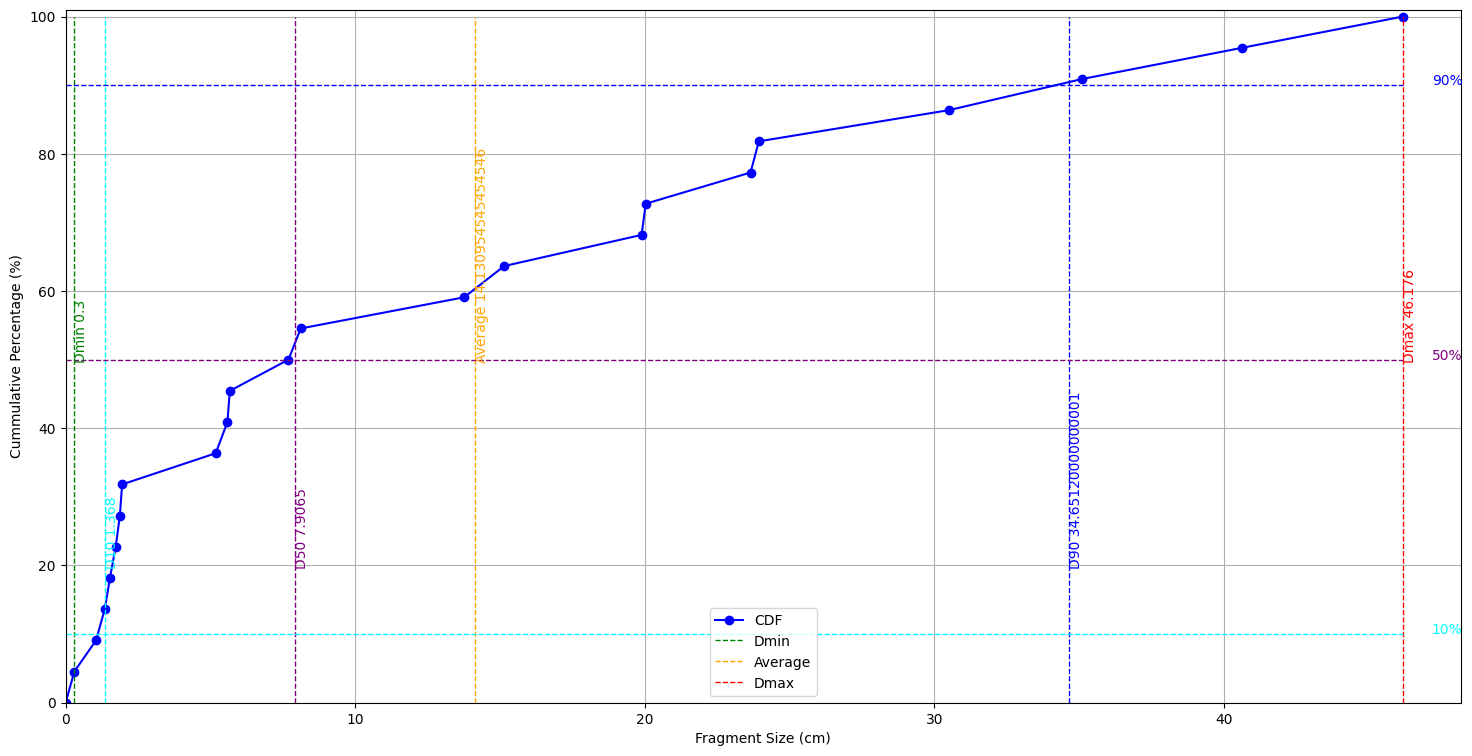

In [ ]:
def calculate_size(boxes):
    x1, y1, x2, y2 = boxes
    return (y2 - y1) * (x2 - x1)

def conversion_func(size):
    '''
    Convert from area of bounding boxes to real-world scale  
    '''
    conv_rate = 0.003 # 1pixel = 0.003cm = 3mm
    return conv_rate * size

model.eval()
image_path = val_path + '/images/015.jpg'
image = read_image(image_path)
image = image.unsqueeze(0)
image = image.to(device, dtype=torch.float32)
predictions = model(image)

pred = predictions[0]
score_threshold = 0.5 # You can adjust this
keep = pred["scores"] > score_threshold
pred_boxes_filtered = pred["boxes"][keep].long()
pred_scores_filtered = pred["scores"][keep]
pred_labels_filtered = pred["labels"][keep]
pred_masks_raw_filtered = pred["masks"][keep]

cnt_rocks = len(pred_boxes_filtered)
sizes = []
for i in range(cnt_rocks):
    size_i = calculate_size(pred_boxes_filtered[i].cpu().numpy())
    size_i = conversion_func(size_i)
    sizes.append(size_i)

d_min = np.min(sizes)
d_ave = np.average(sizes)
d_max = np.max(sizes)
d_10 = np.percentile(sizes, 10)
d_50 = np.percentile(sizes, 50)
d_90 = np.percentile(sizes, 90)
# X = arange(0, max(100, size_max))
# Y = 
# plt.title(f'Cummulative Distribution Function (CDF) of Fragment Sizes\nTotal Fragments: {cnt_rocks}')
# plt.plot(X, Y, 'b')
# plt.show()

sizes.append(0.0)
cnt_rocks = cnt_rocks 
sizes.sort()
cdf_sorted = np.arange(0, cnt_rocks + 1) / cnt_rocks * 100

plt.figure(figsize=(18, 9))
plt.plot(sizes, cdf_sorted, color='#0000FF', marker='o', label='CDF')
# Dmin, Average, Dmax
plt.plot([d_min, d_min], [0, 100], color='green', linestyle='dashed', lw=1, label='Dmin')
plt.plot([d_ave, d_ave], [0, 100], color='orange', linestyle='dashed', lw=1, label='Average')
plt.plot([d_max, d_max], [0, 100], color='red', linestyle='dashed', lw=1, label='Dmax')
plt.text(d_min, 50, f'Dmin {d_min}', rotation=90, color='green')
plt.text(d_ave, 50, f'Average {d_ave}', rotation=90, color='orange')
plt.text(d_max, 50, f'Dmax {d_max}', rotation=90, color='red')
# D10, D50, D90
plt.plot([d_10, d_10], [0, 100], color='cyan', linestyle='dashed', lw=1)
plt.plot([d_50, d_50], [0, 100], color='purple', linestyle='dashed', lw=1)
plt.plot([d_90, d_90], [0, 100], color='blue', linestyle='dashed', lw=1)
plt.text(d_10, 20, f'D10 {d_10}', rotation=90, color='cyan')
plt.text(d_50, 20, f'D50 {d_50}', rotation=90, color='purple')
plt.text(d_90, 20, f'D90 {d_90}', rotation=90, color='blue')
# 10%, 50%, 90%
plt.plot([0, d_max], [10, 10], color='cyan', linestyle='dashed', lw=1)
plt.plot([0, d_max], [50, 50], color='purple', linestyle='dashed', lw=1)
plt.plot([0, d_max], [90, 90], color='blue', linestyle='dashed', lw=1)
plt.text(d_max+1, 10, f'10%', rotation=0, color='cyan')
plt.text(d_max+1, 50, f'50%', rotation=0, color='purple')
plt.text(d_max+1, 90, f'90%', rotation=0, color='blue')

plt.legend()
plt.xlabel('Fragment Size (cm)')
plt.ylabel('Cummulative Percentage (%)')
plt.xlim(xmin=0, xmax=d_max+2)
plt.ylim(ymin=0, ymax=100+1)
plt.grid('True')
plt.show()